In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import random

In [51]:
#Зафиксируем seed для воспроизводимости
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch

In [52]:
seed_everything(42)

In [53]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [54]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [55]:
# install for train and test
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

In [56]:
from torch.utils.data import DataLoader

batch_size = 256

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [58]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [59]:
class Net(nn.Module):
    def __init__(self, latent_size=10):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    

In [60]:
model = Net(2)

In [61]:
criterion = nn.CrossEntropyLoss()      
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [62]:
losses_train = []
losses_test = []
for epoch in range(11):
    history_train = []
    history_test = []
    for x_batch, y_batch in train_loader:
    # 1. # загружаем батч данных (вытянутый в линию)
        x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
        y_batch = y_batch.to(device)

    # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
        preds = model(x_batch)

    # 3. вычислеяем - функцию потерь (loss)
        loss = criterion(preds, y_batch)
        #history.append(loss.item())

    # 4. вычисляем градиенты
        optimizer.zero_grad()
        loss.backward()

    # 5. шаг градиентного спуска
        optimizer.step()
        history_train.append(loss.item())
    losses_train.append(np.mean(history_train))
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
            y_batch = y_batch.to(device)
            
            preds = model(x_batch)
            
            loss = criterion(preds, y_batch)
            
            history_test.append(loss.item())
    
    losses_test.append(np.mean(history_test))       
    print(f'{epoch+1},\t loss: {history_train[-1]}')
    print(f'{epoch+1},\t loss: {history_test[-1]}')

1,	 loss: 6.725009441375732
1,	 loss: 6.695545196533203
2,	 loss: 6.634446144104004
2,	 loss: 6.611154079437256
3,	 loss: 6.55354642868042
3,	 loss: 6.5292158126831055
4,	 loss: 6.481447219848633
4,	 loss: 6.456350326538086
5,	 loss: 6.410762786865234
5,	 loss: 6.385681629180908
6,	 loss: 6.340761661529541
6,	 loss: 6.316172122955322
7,	 loss: 6.271427631378174
7,	 loss: 6.247615814208984
8,	 loss: 6.20287561416626
8,	 loss: 6.18000602722168
9,	 loss: 6.135045528411865
9,	 loss: 6.113279819488525
10,	 loss: 6.040256977081299
10,	 loss: 6.0295844078063965
11,	 loss: 5.927290439605713
11,	 loss: 5.920024394989014


In [63]:
for batch in test_loader:
    data = batch[0].float()
    target = batch[1].float()
    break

In [64]:
data=data.view(-1,28*28)

In [65]:
target=target.detach().cpu().numpy().astype(int).astype(str)
#Так вроде бы получше выглядит

In [66]:
s=model.E(data)
s=s.detach().numpy()
s

array([[0.98495805, 0.9999238 ],
       [0.0384411 , 0.99749774],
       [0.2257587 , 0.23810406],
       [0.49190918, 0.99999976],
       [0.96098256, 0.99996436],
       [0.34169623, 0.18463811],
       [0.7220056 , 0.9998934 ],
       [0.6660988 , 0.99935716],
       [0.9332082 , 0.9982828 ],
       [0.97060806, 0.9999894 ],
       [0.61758775, 0.9999639 ],
       [0.27729845, 0.99958974],
       [0.9922619 , 0.9999871 ],
       [0.9497371 , 0.99999785],
       [0.08853082, 0.1705635 ],
       [0.24262904, 0.9988788 ],
       [0.99406403, 0.9999925 ],
       [0.90198493, 0.99997747],
       [0.01548256, 0.9991584 ],
       [0.93503034, 0.999889  ],
       [0.88909644, 0.9999747 ],
       [0.01931357, 0.999979  ],
       [0.32495594, 0.99620616],
       [0.28860152, 0.9998373 ],
       [0.93170893, 0.9996619 ],
       [0.7879646 , 1.        ],
       [0.9401455 , 0.99952745],
       [0.96820235, 0.99998784],
       [0.7595582 , 0.9999995 ],
       [0.06138433, 0.53906476],
       [0.

C:\Users\zhuko\anaconda3\lib\site-packages\seaborn\_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


<AxesSubplot:>

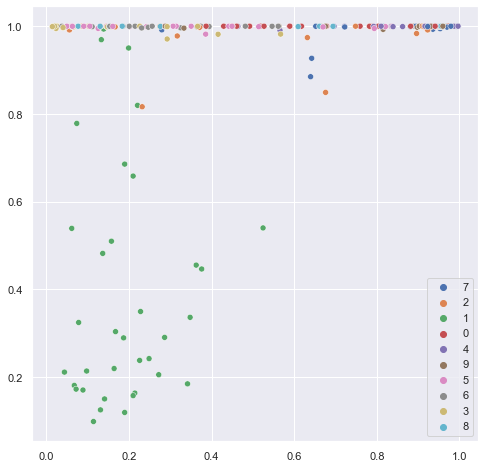

In [67]:
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(data=s, x=s[:,0], y=s[:,-1], hue=target)

In [68]:
model_32 = Net(32)

In [69]:
optimizer_32 = torch.optim.Adam(model_32.parameters(), lr=1e-4)

In [70]:
losses_train = []
losses_test = []
for epoch in range(10):
    history_train = []
    history_test = []
    for x_batch, y_batch in train_loader:
    # 1. # загружаем батч данных (вытянутый в линию)
        x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
        y_batch = y_batch.to(device)

    # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
        preds = model_32(x_batch)

    # 3. вычислеяем - функцию потерь (loss)
        loss = criterion(preds, y_batch)
        #history.append(loss.item())

    # 4. вычисляем градиенты
        optimizer_32.zero_grad()
        loss.backward()

    # 5. шаг градиентного спуска
        optimizer_32.step()
        history_train.append(loss.item())
    losses_train.append(np.mean(history_train))
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
            y_batch = y_batch.to(device)
            
            preds = model_32(x_batch)
            
            loss = criterion(preds, y_batch)
            
            history_test.append(loss.item())
    
    losses_test.append(np.mean(history_test))       
    print(f'{epoch+1},\t loss: {history_train[-1]}')
    print(f'{epoch+1},\t loss: {history_test[-1]}')

1,	 loss: 5.587246894836426
1,	 loss: 5.592343807220459
2,	 loss: 5.052779674530029
2,	 loss: 5.055705547332764
3,	 loss: 4.886003494262695
3,	 loss: 4.886662483215332
4,	 loss: 4.825390815734863
4,	 loss: 4.8254313468933105
5,	 loss: 4.797603607177734
5,	 loss: 4.7975544929504395
6,	 loss: 4.782125949859619
6,	 loss: 4.782068729400635
7,	 loss: 4.7724385261535645
7,	 loss: 4.772390365600586
8,	 loss: 4.765899658203125
8,	 loss: 4.765861511230469
9,	 loss: 4.761246681213379
9,	 loss: 4.76121711730957
10,	 loss: 4.757803916931152
10,	 loss: 4.757781028747559


In [71]:
for batch in test_loader:
    data_32 = batch[0].float()
    target_32 = batch[1].float()
    break

In [72]:
data_32=data_32.view(-1,28*28)

In [73]:
s_32=model_32.E(data_32)
s_32=s_32.detach().numpy()
s_32

array([[0.9995466 , 0.99992573, 0.99883336, ..., 0.9993703 , 0.99959594,
        0.99978715],
       [0.9990688 , 0.99842167, 0.9997218 , ..., 0.999632  , 0.99891675,
        0.9997619 ],
       [0.9998745 , 0.99957174, 0.99992764, ..., 0.9997825 , 0.99985504,
        0.9998349 ],
       ...,
       [0.9997763 , 0.99942136, 0.99962246, ..., 0.9997154 , 0.99970883,
        0.99974114],
       [0.9996513 , 0.99981946, 0.9986186 , ..., 0.99940705, 0.99964535,
        0.9998423 ],
       [0.99976   , 0.99969196, 0.99936   , ..., 0.9996049 , 0.99978   ,
        0.9997873 ]], dtype=float32)

In [74]:
s_32.shape

(256, 32)

In [75]:
from sklearn.manifold import TSNE

In [76]:
tsne = TSNE(n_components=2, random_state=42)

In [77]:
X_tsne = tsne.fit_transform(s_32)

In [78]:
X_tsne.shape

(256, 2)

In [79]:
X_tsne

array([[ 6.27241755e+00,  2.78950214e-01],
       [-1.66636410e+01,  8.04084682e+00],
       [ 1.50003366e+01, -6.01044750e+00],
       [-1.29616537e+01,  8.88787174e+00],
       [ 4.46707582e+00, -1.03656206e+01],
       [-6.08235896e-01, -7.02742386e+00],
       [ 1.61290061e+00, -9.12924099e+00],
       [-2.52862787e+00,  2.75871134e+00],
       [-5.14188623e+00,  8.14453840e-01],
       [ 5.95939875e+00,  1.48712862e+00],
       [ 2.48388910e+00,  6.18110847e+00],
       [-1.51717138e+01,  8.96001148e+00],
       [ 6.51232290e+00, -1.02270613e+01],
       [ 4.58742714e+00,  9.56201315e-01],
       [ 1.56328430e+01, -6.00941229e+00],
       [ 6.88224602e+00,  3.69199133e+00],
       [ 4.14034986e+00, -9.17054749e+00],
       [-4.80445099e+00,  2.17995071e+00],
       [-1.82525768e+01,  8.16374302e+00],
       [ 5.65724134e+00, -1.03694172e+01],
       [ 6.33680916e+00,  1.57246876e+00],
       [-7.19938374e+00,  1.01343212e+01],
       [-3.58411837e+00,  4.76407766e+00],
       [-3.

<AxesSubplot:>

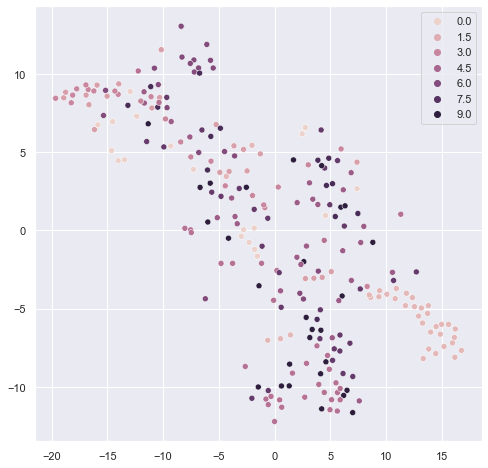

In [80]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(data=s_32, x=X_tsne[:,0], y=X_tsne[:,-1], hue=target_32)

In [81]:
class Encoder(nn.Module):
    def __init__(self, latent_size=64):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=64):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [82]:
class Net(nn.Module):
    def __init__(self, latent_size=64, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [83]:
models = {'16': Net(16), '32': Net(32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [84]:
for batch in test_loader:
    data_n = batch[0].float()
    target_n = batch[1].float()
    break

In [85]:
data_n=data_n.view(-1,28*28)

In [86]:
data_n.shape

torch.Size([256, 784])

In [87]:
#Добавим гауссовский шум к данным + сделаем отражение части изображения

In [88]:
mu, sigma = 0, 0.1
noise = np.random.normal(mu, sigma, [256,784])
data_noized=data_n+noise
data_noized=torch.fliplr(data_noized)

In [89]:
data_n = [d.reshape(28,28) for d in data_n]

In [90]:
data_noized = [d.reshape(28,28) for d in data_noized]

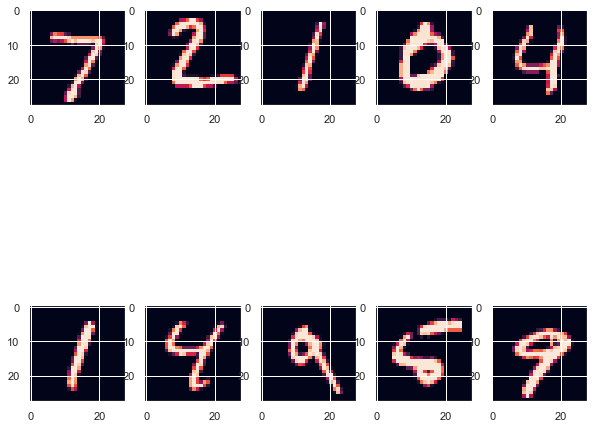

In [91]:
fig, axs = plt.subplots(2, 5, figsize=(10, 10))
axs[0, 0].imshow(data_n[0])
axs[0, 1].imshow(data_n[1])
axs[0, 2].imshow(data_n[2])
axs[0, 3].imshow(data_n[3])
axs[0, 4].imshow(data_n[4])
axs[1, 0].imshow(data_n[5])
axs[1, 1].imshow(data_n[6])
axs[1, 2].imshow(data_n[7])
axs[1, 3].imshow(data_n[8])
axs[1, 4].imshow(data_n[9])

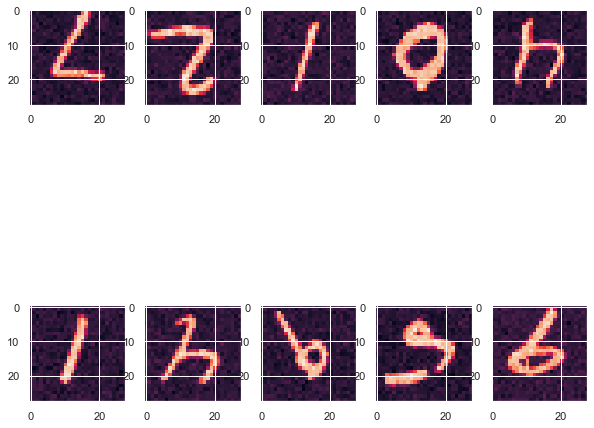

In [92]:
fig, axs = plt.subplots(2, 5, figsize=(10, 10))
axs[0, 0].imshow(data_noized[0])
axs[0, 1].imshow(data_noized[1])
axs[0, 2].imshow(data_noized[2])
axs[0, 3].imshow(data_noized[3])
axs[0, 4].imshow(data_noized[4])
axs[1, 0].imshow(data_noized[5])
axs[1, 1].imshow(data_noized[6])
axs[1, 2].imshow(data_noized[7])
axs[1, 3].imshow(data_noized[8])
axs[1, 4].imshow(data_noized[9])

In [103]:
def add_noise(x, mode='gaussian', elementwise=True):
    if np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        if mode == 'gaussian':
            for i in range(x.shape[0]):
                x=x+(0.1**0.5)*torch.randn(256, 1, 28,28) 
    else:
        if mode == 'mirror':
            x=torch.fliplr(x)
    return x

In [104]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [105]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            if np.random.randint(2):
                noized = add_noise(data, mode='gaussian')
            else:
                noized = add_noise(data, mode='mirror')
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [106]:
for epoch in range(1, 11):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 16: 0.267438 32: 0.255368
Train Epoch: 1 [38400/60000] 16: 0.272803 32: 0.259797
Train Epoch: 1 [59904/60000] 16: 0.275574 32: 0.252369
Test set:
16: loss: 0.2721
32: loss: 0.2516

Train Epoch: 2 [00000/60000] 16: 0.266483 32: 0.242839
Train Epoch: 2 [38400/60000] 16: 0.271425 32: 0.246514
Train Epoch: 2 [59904/60000] 16: 0.275015 32: 0.260703
Test set:
16: loss: 0.2710
32: loss: 0.2481

Train Epoch: 3 [00000/60000] 16: 0.265889 32: 0.250615
Train Epoch: 3 [38400/60000] 16: 0.269427 32: 0.242505
Train Epoch: 3 [59904/60000] 16: 0.274100 32: 0.258188
Test set:
16: loss: 0.2690
32: loss: 0.2442

Train Epoch: 4 [00000/60000] 16: 0.263215 32: 0.235125
Train Epoch: 4 [38400/60000] 16: 0.269313 32: 0.254730
Train Epoch: 4 [59904/60000] 16: 0.270181 32: 0.241141
Test set:
16: loss: 0.2671
32: loss: 0.2406

Train Epoch: 5 [00000/60000] 16: 0.263028 32: 0.249031
Train Epoch: 5 [38400/60000] 16: 0.263496 32: 0.235430
Train Epoch: 5 [59904/60000] 16: 0.265102 32: 0.23

In [107]:
for batch in test_loader:
    data = batch[0].float()
    target = batch[1].float()
    break

In [108]:
data = [d.reshape(28,28) for d in data]

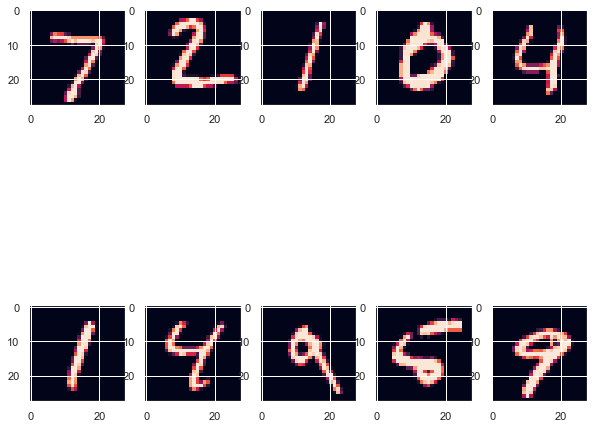

In [109]:
fig, axs = plt.subplots(2, 5, figsize=(10, 10))
axs[0, 0].imshow(data_n[0])
axs[0, 1].imshow(data_n[1])
axs[0, 2].imshow(data_n[2])
axs[0, 3].imshow(data_n[3])
axs[0, 4].imshow(data_n[4])
axs[1, 0].imshow(data_n[5])
axs[1, 1].imshow(data_n[6])
axs[1, 2].imshow(data_n[7])
axs[1, 3].imshow(data_n[8])
axs[1, 4].imshow(data_n[9])

In [113]:
data, _ = next(iter(test_loader))
noized = add_noise(data, elementwise=True)
output = models['32'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

In [114]:
to_plot = [d.reshape(28,28) for d in to_plot]

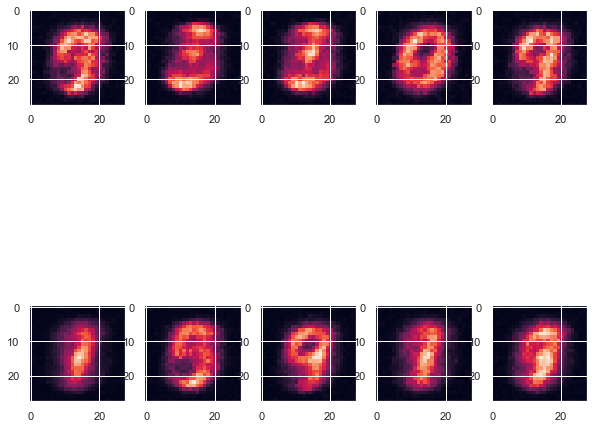

In [115]:
fig, axs = plt.subplots(2, 5, figsize=(10, 10))
axs[0, 0].imshow(to_plot[0])
axs[0, 1].imshow(to_plot[1])
axs[0, 2].imshow(to_plot[2])
axs[0, 3].imshow(to_plot[3])
axs[0, 4].imshow(to_plot[4])
axs[1, 0].imshow(to_plot[5])
axs[1, 1].imshow(to_plot[6])
axs[1, 2].imshow(to_plot[7])
axs[1, 3].imshow(to_plot[8])
axs[1, 4].imshow(to_plot[9])